In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np
import pickle
import os
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from pygam import LinearGAM, s, f
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [6]:
def pickleLoad(file):
    if os.path.isfile(file):        
        with open(file,"rb") as fr:
            dataframe = pickle.load(fr)
        return dataframe
    else:  
        %run -i './getTrainTestSet/getTrainTestSet.py' 

In [7]:
# load train, test set data

X_train = pickleLoad('./dataset/dataset_mean/X_train.pkl')
X_test = pickleLoad('./dataset/dataset_mean/X_test.pkl')
y_train = pickleLoad('./dataset/dataset_mean/y_train.pkl')
y_test = pickleLoad('./dataset/dataset_mean/y_test.pkl')
ccsi = pickleLoad('./dataset/dataset_mean/ccsi.pkl')
predictors = pickleLoad('./dataset/dataset_mean/predictors.pkl')

* data preprocessing(standard scaling)

In [8]:
########## 변수 스케일링
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### model 1. multiple linear regression

* 10-fold CV

In [9]:
model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
rmse_linearRegressionCV = np.sqrt(-scores)
rmse_lravg = rmse_linearRegressionCV.mean()
rmse_lrstd = rmse_linearRegressionCV.std()

In [10]:
print(" 10-fold cv RMSE: ", rmse_linearRegressionCV)
print("최종 CV RMSE = ", rmse_lravg)

 10-fold cv RMSE:  [5.30506411 1.31251553 5.635988   2.56820887 3.69628061 2.73889619
 3.11588235 2.20547023 3.62550589 4.04455451]
최종 CV RMSE =  3.4248366302639885


### model 2: Random Forest

In [11]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [12]:
# CV
rmse_randomforest, parameters_randomforest = [], []
numOfEstimators = np.power(2, [3,4,5,6])
maxFeatures = [1,2,3,4,5]
for i in maxFeatures:
    for j in numOfEstimators:
        # parameter search
        model_forest = RandomForestRegressor(max_features = i, n_estimators = j, warm_start = True, random_state = 23)
        parameters_randomforest.append(model_forest.get_params)
        # 10-fold CV
        scores = cross_val_score(model_forest, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
        rmse_randomforest.append(np.sqrt(-scores))
    

In [13]:
def getCVResult(rmse_list, model_num):
    cv_rmse =  rmse_list[model_num - 1].mean()
    std = rmse_list[model_num - 1].std()

    return cv_rmse, std

In [14]:
rmse_list, std_list = [], []
for i in range(1,21):
    cv_rmse, std = getCVResult(rmse_randomforest, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)
    

1 3.626294290844263 0.8993603789306619
2 3.36376677304278 1.1135773623264205
3 3.194857193654152 0.8352757675519137
4 3.020641267484188 1.0157711926838413
5 2.94324211843914 1.022355607651214
6 3.0242914123367712 1.0146565229258904
7 2.734554223456927 0.9503578765418463
8 2.714717945133866 0.8454844203922269
9 2.7614332540040083 0.7336326413340817
10 2.7405745595877717 0.7463605114338443
11 2.6721483862956035 0.7067071623639751
12 2.6143745525345325 0.7876477235189219
13 2.7133143899539007 0.6907706448374128
14 2.5960592759368 0.7314323126646662
15 2.499711261782822 0.7898425008034824
16 2.476451180218052 0.6977809510225087
17 2.655272664818508 0.7729608539360898
18 2.43173853641663 0.7928322912626684
19 2.3968982908710172 0.7912916342329765
20 2.4853613520616276 0.7426975760189951


#### final random forest model selection

In [15]:
rmse_list.index(min(rmse_list))

18

model 후보 1~20번 중에, 19번모델이 가장 낮은 rmse 평균값을 갖고있음을 확인할 수 있다.

따라서, 19번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [16]:
# 대표 모델의 파라미터
parameters_randomforest[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of RandomForestRegressor(max_features=5, n_estimators=32, random_state=23,
                      warm_start=True)>

In [17]:
# 대표 모델의 평균 rmse와 std
rmse_forestavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_foreststd = std_list[rmse_list.index(min(rmse_list))]

In [18]:
# 대표 모델의 10-fold cv
rmse_randomforestCV = rmse_randomforest[rmse_list.index(min(rmse_list))]
rmse_randomforestCV

array([3.56942939, 2.03233625, 1.0260827 , 2.38873005, 3.01224454,
       2.59212336, 1.90523154, 1.36008692, 2.6474362 , 3.43528195])

In [19]:
print(" 10-fold cv RMSE: ", rmse_randomforestCV)
print("최종 CV RMSE = ", rmse_forestavg)

 10-fold cv RMSE:  [3.56942939 2.03233625 1.0260827  2.38873005 3.01224454 2.59212336
 1.90523154 1.36008692 2.6474362  3.43528195]
최종 CV RMSE =  2.3968982908710172


### model 3: GAM

In [20]:
X_train = pd.DataFrame(X_train, columns = ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver'])

In [21]:
# CV
rmse_gamCV = []
np.random.seed(1)
lams = np.random.rand(100, 7) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 

K=10
for k in range(K):
    if k < 3:
        val_ind = (range(4 * k, 4 * k + 4))
    else:
        val_ind = (range(5 * (k-1)+1, 5 * (k-1)+6))
    X_train2 = X_train.drop(val_ind).to_numpy()
    y_train2 = y_train.drop(val_ind).to_numpy()
    X_val = X_train.loc[val_ind, :].to_numpy()
    y_val = y_train.loc[val_ind, :].to_numpy()
    # parameter search
    model_gam =  LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)+ s(6)).gridsearch(X_train2, y_train2, lam = lams)
    y_hat = model_gam.predict(X_val)
    scores = mean_squared_error(y_val, y_hat)
    rmse_gamCV.append(np.sqrt(scores))
    
    

100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09


In [22]:
rmse_gamavg = np.mean(rmse_gamCV)
rmse_gamstd = np.std(rmse_gamCV)

In [23]:
print(" 10-fold cv RMSE: ", rmse_gamCV)
print("최종 CV RMSE = ", rmse_gamavg)

 10-fold cv RMSE:  [9.999772988522182, 6.500046404386535, 1.7354205965118683, 6.1807715838298645, 7.21123346715382, 9.819124368480093, 7.540747263470443, 11.961521807128378, 6.07913356412391, 5.016657589078493]
최종 CV RMSE =  7.204442963268559


### model 4: Lasso Regression

In [24]:
# CV
rmse_lasso, parameters_lasso = [], []
alpha = [10, 1, 0.1, 0.01, 0.001]
for i in alpha:
    # parameter search
    model_lasso = Lasso(alpha = i, random_state = 23)
    parameters_lasso.append(model_lasso.get_params)
    # 10-fold CV
    scores = cross_val_score(model_lasso, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
    rmse_lasso.append(np.sqrt(-scores))
    

In [25]:
rmse_list, std_list = [], []
for i in range(1, 6):
    cv_rmse, std = getCVResult(rmse_lasso, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)

1 5.738183320169615 1.2898070743884191
2 3.3974991886755523 0.5982984907231543
3 2.866412504509192 1.0299037458589066
4 2.881869746591952 1.1598322470917435
5 2.893100532775214 1.2088251028997066


#### final lasso linear regression model selection

In [26]:
rmse_list.index(min(rmse_list))

2

model 후보 1~5번 중에, 3번모델이 가장 낮은 rmse 평균값을 갖고 있음을 확인할 수 있다.

따라서, 3번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [27]:
# 대표 모델의 파라미터
parameters_lasso[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of Lasso(alpha=0.1, random_state=23)>

In [28]:
# 대표 모델의 평균 rmse와 std
rmse_lassoavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_lassostd = std_list[rmse_list.index(min(rmse_list))]

In [29]:
# 대표 모델의 10-fold cv
rmse_lassoCV = rmse_lasso[rmse_list.index(min(rmse_list))]
rmse_lassoCV 

array([4.44122803, 2.53074551, 2.80457392, 2.29945506, 2.72018113,
       2.57356804, 1.51707421, 1.95665865, 2.73685484, 5.08378564])

###  Model간 CV RMSE 비교

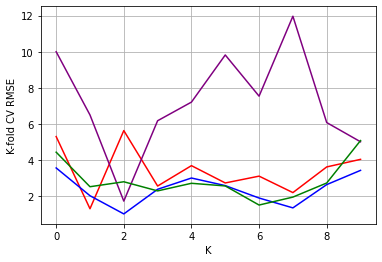

In [30]:
plt.plot(rmse_linearRegressionCV, color = 'red', label = 'Linear Regression')
plt.plot(rmse_randomforestCV, color = 'blue', label = 'Random Forest')
plt.plot(rmse_gamCV, color = 'purple', label = 'Generalized Additive Models')
plt.plot(rmse_lassoCV, color = 'green', label = 'Lasso Linear Regression')
plt.xlabel("K")
plt.ylabel("K-fold CV RMSE")
plt.grid(True)

In [31]:
print(rmse_lravg, rmse_forestavg, rmse_gamavg, rmse_lassoavg)

3.4248366302639885 2.3968982908710172 7.204442963268559 2.866412504509192


## T-test

In [32]:
def tTest(rmse1, rmse2):
    mean = (rmse1 - rmse2).mean()
    sd = (rmse1 - rmse2).std()
    t_statistic = mean / (sd / np.sqrt(10))
    return t_statistic

**H0**: linear regression model의 rmse = Random Forest model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [33]:
mean = np.average(rmse_linearRegressionCV - rmse_randomforestCV)
sd = (rmse_linearRegressionCV - rmse_randomforestCV).std()

tTest(rmse_linearRegressionCV, rmse_randomforestCV)

2.4065469641778177

In [34]:
print(rmse_linearRegressionCV - rmse_randomforestCV)
print(mean)

[ 1.73563472 -0.71982072  4.60990531  0.17947882  0.68403606  0.14677283
  1.21065081  0.84538331  0.97806969  0.60927255]
1.0279383393929713


t_0.025,9 = 2.262 <br><br>

|t-value| = 2.407 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다.  따라서, linear regression model과 Random forest model의 성능에는 차이가 있다. 이때 linear와 rf의 cv rmse값을 뺀것이 양수이기때문에, rf의 rmse가 linear의 rmse보다 작다. 즉, **rf 모델이 성능이 좋다. **

**H0**: linear regression model의 rmse = GAM model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [35]:
mean = np.average(rmse_linearRegressionCV - rmse_gamCV)
sd = np.std(rmse_linearRegressionCV - rmse_gamCV)

tTest(rmse_linearRegressionCV, rmse_gamCV)

-3.471016812901125

In [36]:
print(rmse_linearRegressionCV - rmse_gamCV)
print(mean)

[-4.69470888 -5.18753087  3.90056741 -3.61256271 -3.51495286 -7.08022817
 -4.42486491 -9.75605158 -2.45362767 -0.97210308]
-3.77960633300457


t_0.025,9 = 2.262 <br><br>

|t-value| = 3.471 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다.  따라서, linear regression model과 GAM model의 성능에는 차이가 있다. 이때 linear와 GAM의 cv rmse값을 뺀것이 음수이기때문에, linear의 rmse가 GAM의 rmse보다 작다. 즉, **linear 모델이 성능이 좋다. **



**H0**: linear regression model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [37]:
mean = np.average(rmse_linearRegressionCV - rmse_lassoCV)
sd = (rmse_linearRegressionCV - rmse_lassoCV).std()

tTest(rmse_linearRegressionCV, rmse_lassoCV) 

1.5688945293298218

t_0.025,9 = 2.262 <br><br>

|t-value| = 1.569 < t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 Lasso linear regression model의 성능에는 차이가 없다. 

**H0**: Random Forest model의 rmse = GAM model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [38]:
mean = np.average(rmse_randomforestCV - rmse_gamCV)
sd = (rmse_randomforestCV - rmse_gamCV).std()

tTest(rmse_randomforestCV, rmse_gamCV)

-5.613156658969855

In [39]:
print(rmse_randomforestCV - rmse_gamCV)
print(mean)

[ -6.4303436   -4.46771016  -0.7093379   -3.79204153  -4.19898892
  -7.22700101  -5.63551572 -10.60143489  -3.43169736  -1.58137563]
-4.807544672397542


t_0.025,9 = 2.262 <br><br>

|t-value| = 5.613 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, random forest model과 GAM model의 성능에는 차이가 있다. 이때 rf와 GAM의 cv rmse값을 뺀것이 음수이기때문에, rf의 rmse가 GAM의 rmse보다 작다. 즉, **rf 모델이 성능이 좋다. **


**H0**: Random Forest model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [40]:
mean = np.average(rmse_randomforestCV - rmse_lassoCV)
sd = (rmse_randomforestCV - rmse_lassoCV).std()

tTest(rmse_randomforestCV, rmse_lassoCV)

-2.04083013294331

In [41]:
print(rmse_randomforestCV - rmse_lassoCV)
print(mean)

[-0.87179864 -0.49840926 -1.77849123  0.08927499  0.29206341  0.01855532
  0.38815733 -0.59657174 -0.08941863 -1.64850369]
-0.46951421363817536


t_0.025,9 = 2.262 <br><br>

|t-value| = 2.041 < t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, random forest model과 Lasso linear regression model의 성능에는 차이가 없다.


**H0**: GAM model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [42]:
mean = np.average(rmse_gamCV - rmse_lassoCV)
sd = (rmse_gamCV - rmse_lassoCV).std()

tTest(rmse_gamCV, rmse_lassoCV)

4.453062867275666

In [43]:
print(rmse_gamCV - rmse_lassoCV)
print(mean)

[ 5.55854495  3.9693009  -1.06915333  3.88131652  4.49105233  7.24555632
  6.02367306 10.00486315  3.34227873 -0.06712805]
4.338030458759365


t_0.025,9 = 2.262 <br><br>

|t-value| = 4.453 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, GAM model과 lasso linear regression model의 성능에는 차이가 있다. 이때 GAM과 lasso의 cv rmse값을 뺀것이 양수이기때문에, lasso의 rmse가 GAM의 rmse보다 작다. 즉, **lasso 모델이 성능이 좋다. **

#### 6번의 T-검정 결과, 해당 데이터 분할 방법에서는 <br>
1. max_features=5, n_estimators=16, random_state=23, warm_start=True 파라미터의 random forest<br>
2. linear regression<br>
3. alpha=0.001, random_state = 23 파라미터의 lasso linear regression

가 비슷한 성능으로 좋게나온다. 따라서 test RMSE기준으로 선택하겠다.

## Testing
* model 1: rf
* model 2: linear
* model 3: lasso

In [44]:
# 최종 선택 모델 재적합
model_final1 = RandomForestRegressor(max_features = 5, n_estimators = 32, warm_start = True, random_state = 23)
model_final1.fit(X_train, y_train)

model_final2 = LinearRegression()
model_final2.fit(X_train, y_train)

model_final3 = Lasso(alpha = 0.1, random_state = 23)
model_final3.fit(X_train, y_train)

Lasso(alpha=0.1, random_state=23)

In [45]:
y_pred1 = model_final1.predict(X_test)
y_pred2 = model_final2.predict(X_test)
y_pred3 = model_final3.predict(X_test)

* model evaluating

In [46]:
print("R square: ", model_final1.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_final1.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred1)))
print("training MAE: ", np.sqrt(mean_absolute_error(y_train, model_final1.predict(X_train))))
print("test MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred1)))

R square:  0.9711668941862701
training RMSE:  0.9619380505933581
test RMSE:  13.361641833752692
training MAE:  0.8552110087956168
test MAE:  3.340292215261017


In [47]:
print("R square: ", model_final2.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_final2.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred2)))
print("training MAE: ", np.sqrt(mean_absolute_error(y_train, model_final2.predict(X_train))))
print("test MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred2)))

R square:  0.8138311625657413
training RMSE:  2.4443021207657387
test RMSE:  9.256904459258926
training MAE:  1.4134016779951422
test MAE:  2.6778169493988346


In [48]:
print("R square: ", model_final3.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_final3.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred3)))
print("training MAE: ", np.sqrt(mean_absolute_error(y_train, model_final3.predict(X_train))))
print("test MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred3)))

R square:  0.8098911051947943
training RMSE:  2.470032170906544
test RMSE:  8.43842267189124
training MAE:  1.4256469738149335
test MAE:  2.567892190420987


## Step5. Visulization
### weekly record 예측하기(weekly CCSI)

In [49]:
# scaling(X_train에 했던 scaling을 그대로 적용)
X = scaler.transform(predictors.loc[:, ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']])

In [50]:
# weekly 레코드들을 예측모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi1 = model_final1.predict(X)
pred_ccsi2 = model_final2.predict(X)
pred_ccsi3 = model_final3.predict(X)

In [51]:
tmp = pd.merge(predictors, ccsi)
tmp['pred1'] = pred_ccsi1
tmp['pred2'] = pred_ccsi2
tmp['pred3'] = pred_ccsi3
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,id,ccsi,pred1,pred2,pred3
0,2016,1,4,825,419,437,986,168,53.0,26.05846,5,99.5,96.478125,101.802486,100.114651
1,2016,1,11,770,348,351,626,182,58.0,25.16599,5,99.5,96.178125,101.503196,100.323007
2,2016,1,18,918,422,441,445,147,74.0,27.38639,5,99.5,96.418750,94.119732,93.526243
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,5,99.5,97.618750,87.764339,88.047484
4,2016,2,1,899,341,485,289,110,63.0,23.01888,6,97.2,97.171875,93.226397,93.178338


In [52]:
# weekly별 단기지표 값에 대한 RMSE
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred1'])))
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred2'])))
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred3'])))

RMSE about weekly CCSI:  6.777860633250357
RMSE about weekly CCSI:  5.835898696480936
RMSE about weekly CCSI:  5.391569937162558


### visaulization
* 시계열 그래프

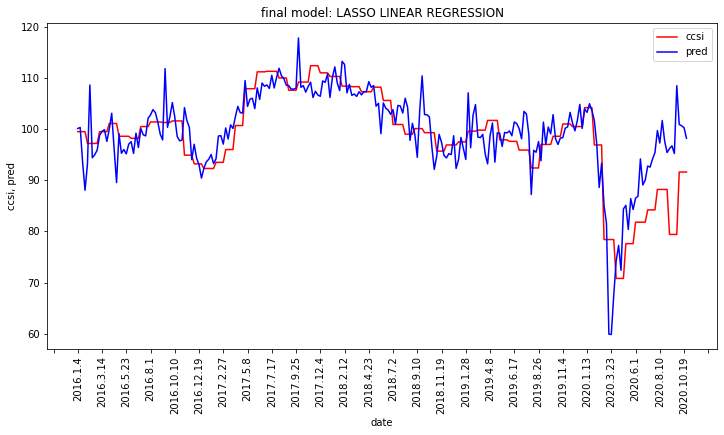

In [53]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred3'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("final model: LASSO LINEAR REGRESSION")
plt.legend()
plt.show()

* moving avg 시계열 그래프

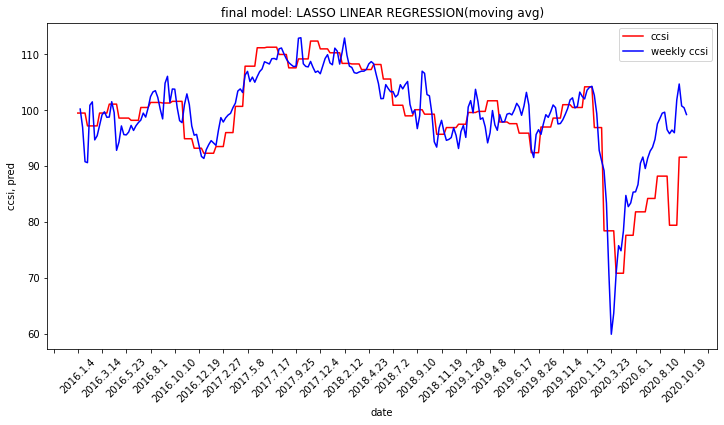

In [54]:
rolling = pd.Series.rolling(tmp['pred3'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("final model: LASSO LINEAR REGRESSION(moving avg)")
plt.legend()
plt.show()

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

## Step6. Develop weekly CCSI(주간 경기선행지수)

In [55]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred3.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred3.iloc[i-1] + tmp.pred3.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp[['date', 'weeklyCLI']]

,date,weeklyCLI
0,2016.1.4,100.114651
1,2016.1.11,100.218829
2,2016.1.18,96.924625
3,2016.1.25,90.786863
4,2016.2.1,90.612911
...,...,...
247,2020.9.28,101.857171
248,2020.10.5,104.707534
249,2020.10.12,100.781811
250,2020.10.19,100.454511


In [57]:
## final 모델 및 주간 지수 결과 저장
pickle.dump(model_final3, open('./final_model.pkl', 'wb'))